In [29]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import random
import os

In [17]:
scaler = MinMaxScaler()

In [19]:
TRAIN_DATASET_PATH = r"BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_t1.nii").get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_t1ce.nii").get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_t2.nii").get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii").get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

1854.603271484375
[0 1 2 4]
[0 1 2 3]


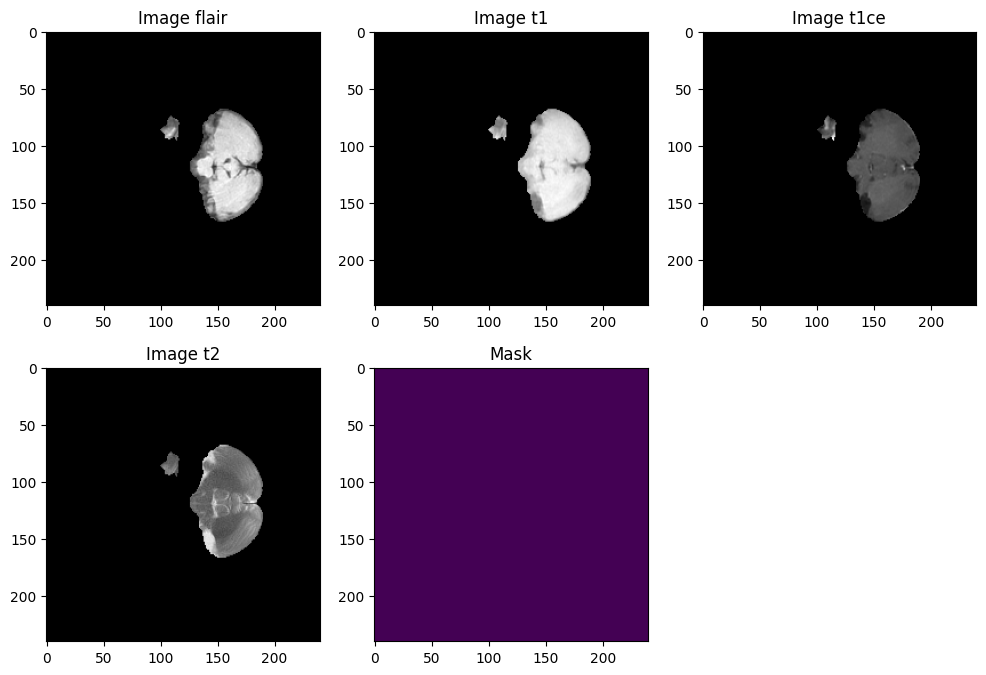

In [21]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [22]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

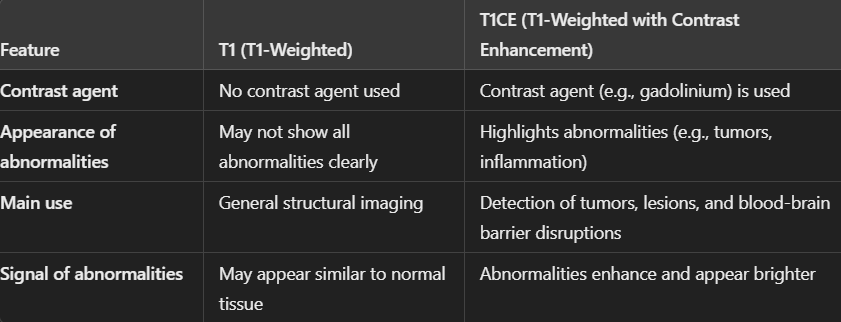


Based on our analysis, the T1CE (T1-weighted contrast-enhanced) modality demonstrates superior diagnostic value compared to the standard T1 modality. To optimize computational efficiency and model performance, we will focus on utilizing the T1CE modality in our subsequent analysis and model development.

In [23]:
test_mask = to_categorical(test_mask, num_classes=4)

In [24]:
t2_list = sorted(glob.glob('BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))


In [30]:
count_use=0
count_waste=0

base_dir = "TrainingData/input_data_3channels"

# Create directories if they don't exist
os.makedirs(os.path.join(base_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "masks"), exist_ok=True)

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  # At least 1% useful volume with labels that are not 0
        count_use += 1
        print("Save Me")
        
        # Convert mask to categorical
        temp_mask = to_categorical(temp_mask, num_classes=4)
        
        # Save image
        image_path = os.path.join(base_dir, "images", f"image_{img}.npy")
        np.save(image_path, temp_combined_images)
        
        # Save mask
        mask_path = os.path.join(base_dir, "masks", f"mask_{img}.npy")
        np.save(mask_path, temp_mask)
        
        print(f"Saved image and mask for img {img}")
    else:
        count_waste+=1
        print("I am useless")   

print("-----------------------------------------------")
print("Number of images saved: ", count_use)
print("Number of images not saved: ", count_waste)
print("Total number of images: ", count_use+count_waste)
print("-----------------------------------------------")

Now preparing image and masks number:  0
Save Me
Saved image and mask for img 0
Now preparing image and masks number:  1
Save Me
Saved image and mask for img 1
Now preparing image and masks number:  2
Save Me
Saved image and mask for img 2
Now preparing image and masks number:  3
Save Me
Saved image and mask for img 3
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Saved image and mask for img 5
Now preparing image and masks number:  6
Save Me
Saved image and mask for img 6
Now preparing image and masks number:  7
Save Me
Saved image and mask for img 7
Now preparing image and masks number:  8
Save Me
Saved image and mask for img 8
Now preparing image and masks number:  9
Save Me
Saved image and mask for img 9
Now preparing image and masks number:  10
Save Me
Saved image and mask for img 10
Now preparing image and masks number:  11
Save Me
Saved image and mask for img 11
Now preparing image and masks number:  12
Save Me
Saved image 